# Demo and Inspection:
# hearing samples, visualizing clusters with plots, etc...

## 1 Gather Audio Samples

In [20]:
from datasets import load_dataset
from collections import Counter
from itertools import islice

dataset = load_dataset(
    "google/speech_commands", "v0.02", split="train", streaming=True, trust_remote_code=True
)

word_counts = Counter()

for sample in islice(dataset, 10000):  # you can increase this to scan more
    label = sample['label']
    word_counts[label] += 1

# Convert label IDs to words if needed
label_names = dataset.features['label'].names
most_common = [(label_names[k], v) for k, v in word_counts.most_common()]
print(most_common[:10])  # top 10 most frequent words

[('down', 1995), ('dog', 1711), ('bird', 1697), ('cat', 1657), ('bed', 1594), ('backward', 1346)]


In [21]:
#IPython.display.Audio can play sample audio 

from datasets import load_dataset
import IPython.display as ipd
from itertools import islice


# Load streaming version — no full download!
dataset = load_dataset(
    "google/speech_commands",
    "v0.02",
    split="train",
    streaming=True,
    trust_remote_code=True
)

# Load feature names to decode label
label_names = dataset.features['label'].names

# Preview a few samples
for sample in islice(dataset, 10):
    audio = sample['audio']
    label_id = sample['label']
    label_name = label_names[label_id]
    print(f"Label ID: {label_id} — Word: {label_name}")
    display(ipd.Audio(audio['array'], rate=audio['sampling_rate']))

Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


Label ID: 30 — Word: backward


In [22]:
# outputs how many samples generated in .csv from load.dataset.py
import pandas as pd

df = pd.read_csv("backward_features.csv")
print("Number of samples:", len(df))
print("Unique speakers:", df['speaker_id'].nunique())

Number of samples: 200
Unique speakers: 200


## Cluster Demo

In [23]:
# Load CSV
import pandas as pd
df = pd.read_csv("backward_features.csv")

In [24]:
# reformatting CSV
# Expand MFCCs back into numeric columns
import ast

# Convert stringified MFCCs to lists
df['mfcc_mean'] = df['mfcc_mean'].apply(ast.literal_eval)

# Expand into separate columns
mfcc_df = pd.DataFrame(df['mfcc_mean'].tolist(), columns=[f'mfcc_{i}' for i in range(13)])

# Combine with rest of the features
df_cleaned = pd.concat([mfcc_df, df.drop(columns=['mfcc_mean', 'speaker_id'])], axis=1)


In [25]:
# Standardize features (very important for PCA + KMeans)
from sklearn.preprocessing import StandardScaler

# Drop metadata not used for clustering
X = df.drop(columns=["speaker_id"])  # drop 'label' if you kept it

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cleaned)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

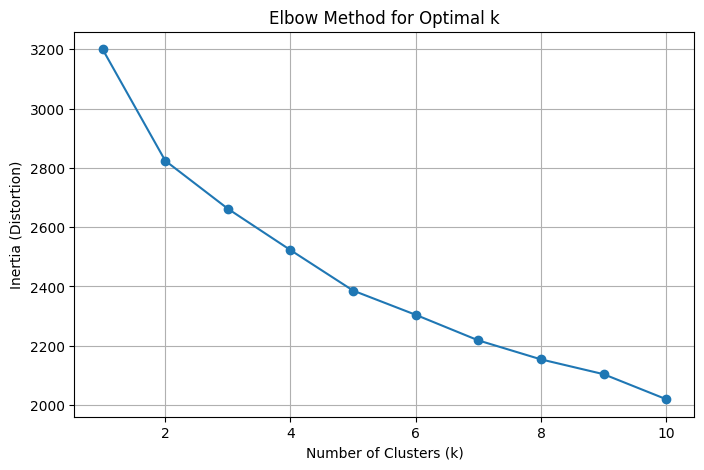

In [26]:
# calculate elbow store

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Range of k values to try
k_range = range(1, 11)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Distortion)")
plt.grid(True)
plt.show()


In [61]:
from sklearn.cluster import KMeans

# Run KMeans clustering (here k = 2)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to DataFrame
df_cleaned["cluster"] = clusters

# View average feature values per cluster
cluster_summary = df_cleaned.groupby("cluster").mean()
display(cluster_summary)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,pitch_mean,tempo,energy_mean,kmeans_cluster,dbscan_cluster,agg_cluster
cluster,,,,,,,,,,,,,,,,,,,
0,-388.793702,110.621211,-12.513186,7.745527,-7.221831,-4.804006,-11.778912,-10.631686,-5.530971,-6.952589,-7.973675,-4.294395,-6.574249,162.894331,174.237653,0.052108,1.472441,-1.0,0.000000
1,-361.705188,118.517919,-1.716522,13.011847,4.351583,4.634099,-4.898977,-1.220884,1.358289,0.034593,-0.008686,1.062473,-3.658800,139.461605,169.224736,0.059087,0.260274,-1.0,0.315068


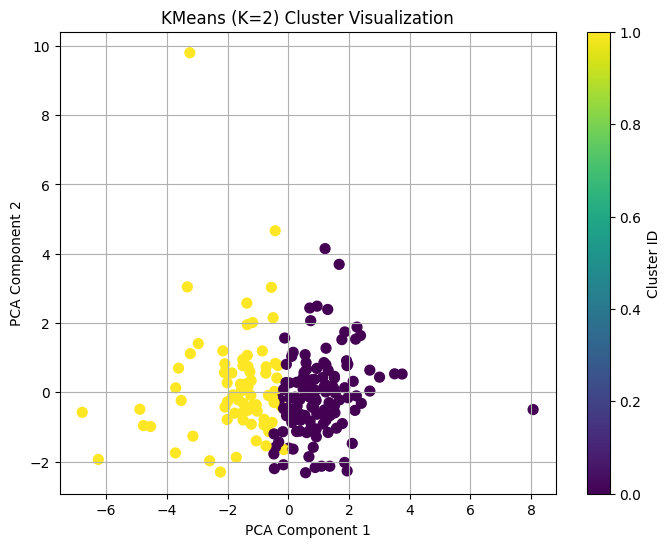

In [62]:
# plotting k = 2 clustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use PCA to reduce to 2D only for visualization (not used for clustering)
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_scaled)

# Plot clusters on 2D PCA projection
plt.figure(figsize=(8, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("KMeans (K=2) Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()

# This plot uses PCA only to reduce the high-dimensional feature space to 2D for visualization.
# Clustering itself was performed on the full, standardized feature set.

In [63]:
from sklearn.cluster import KMeans

# Run KMeans clustering with k = 3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels back to DataFrame
df_cleaned["cluster"] = clusters

# View average feature values per cluster
cluster_summary = df_cleaned.groupby("cluster").mean()
display(cluster_summary)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,pitch_mean,tempo,energy_mean,kmeans_cluster,dbscan_cluster,agg_cluster
cluster,,,,,,,,,,,,,,,,,,,
0,-349.370035,116.493221,-5.775685,15.610815,4.462750,6.036183,-4.350928,-0.707616,1.789008,1.655159,0.598593,2.124633,-2.789815,133.175510,165.236374,0.059279,0.0,-1.0,0.410714
1,-431.907270,112.688908,-3.981384,9.780625,-1.278641,-1.771622,-8.061903,-7.760369,-4.482834,-6.050242,-6.912272,-4.880076,-5.460516,158.613684,189.837144,0.040584,1.0,-1.0,0.000000
2,-335.486465,111.880501,-17.170466,4.150483,-12.009234,-7.493109,-15.303534,-12.312449,-5.417262,-7.693911,-7.742028,-3.010336,-8.032744,167.808493,155.833951,0.069089,2.0,-1.0,0.000000


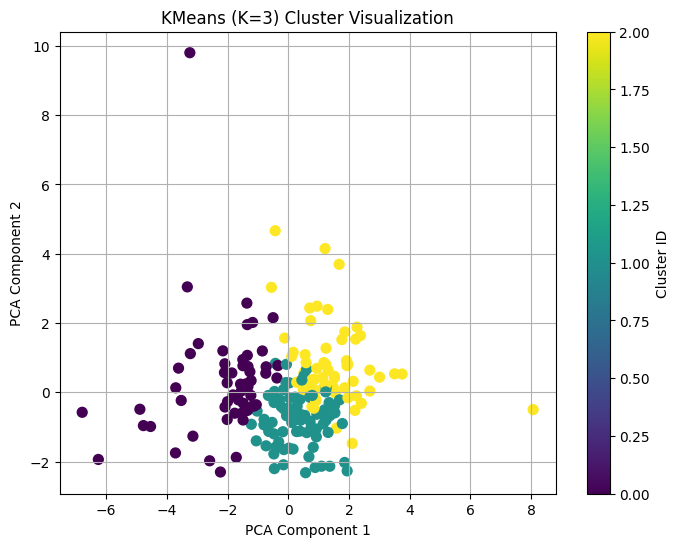

In [64]:
# plotting k = 3 clustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use PCA to reduce to 2D only for visualization (not used for clustering)
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_scaled)

# Plot clusters on 2D PCA projection
plt.figure(figsize=(8, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("KMeans (K=3) Cluster Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()

# This plot uses PCA only to reduce the high-dimensional feature space to 2D for visualization.
# Clustering itself was performed on the full, standardized feature set.


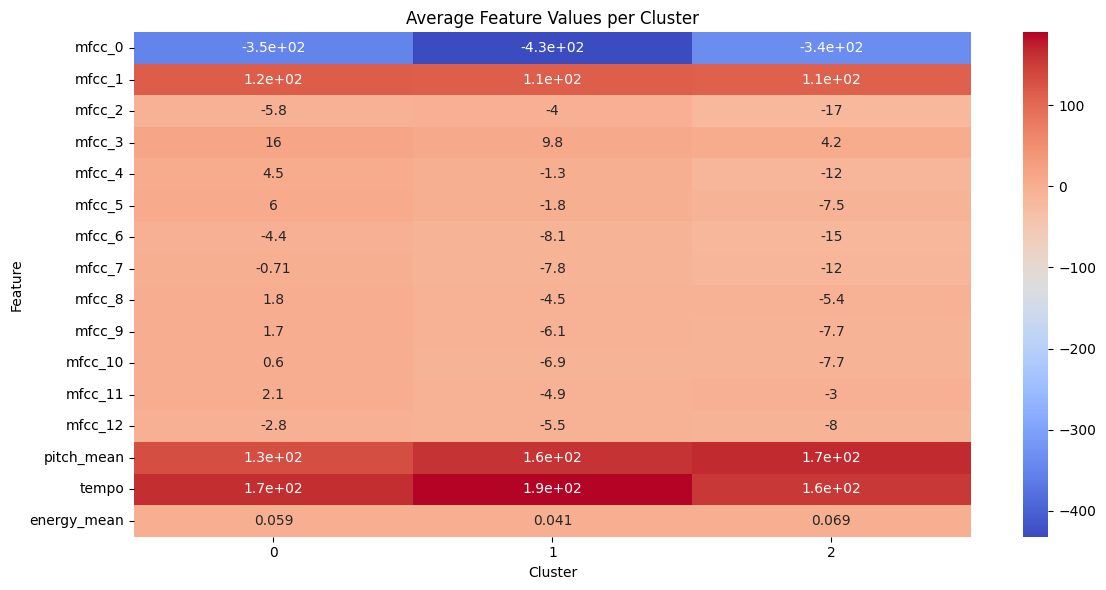

In [30]:
# heat map to understand clustering
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_summary.T, annot=True, cmap="coolwarm")
plt.title("Average Feature Values per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [57]:
from IPython.display import Audio, display

print("🔊 Playing annotated audio examples from each KMeans cluster:")
for cluster_id in sorted(df_cleaned["kmeans_cluster"].unique()):
    print(f"\n🎧 Cluster {cluster_id} examples:")
    
    cluster_indices = df_cleaned["kmeans_cluster"] == cluster_id
    speakers_in_cluster = df.loc[cluster_indices, "speaker_id"].head(2)
    
    for speaker_id in speakers_in_cluster:
        audio = audio_map.get(speaker_id)
        if audio:
            # Get feature row for this speaker
            row = df_cleaned.loc[df["speaker_id"] == speaker_id].iloc[0]
            print(f"- Speaker ID: {speaker_id}")
            print(f"  Pitch: {row['pitch_mean']:.2f}, Tempo: {row['tempo']:.2f}, Energy: {row['energy_mean']:.3f}")
            display(Audio(audio["array"], rate=audio["sampling_rate"]))




🔊 Playing annotated audio examples from each KMeans cluster:

🎧 Cluster 0 examples:
- Speaker ID: b91b718c
  Pitch: 140.27, Tempo: 234.38, Energy: 0.048


- Speaker ID: 85851131
  Pitch: 150.70, Tempo: 125.00, Energy: 0.037



🎧 Cluster 1 examples:
- Speaker ID: 2356b88d
  Pitch: 187.03, Tempo: 208.33, Energy: 0.006


- Speaker ID: 3291330e
  Pitch: 166.57, Tempo: 187.50, Energy: 0.107



🎧 Cluster 2 examples:
- Speaker ID: fc3ba625
  Pitch: 131.92, Tempo: 117.19, Energy: 0.055


- Speaker ID: 06f6c194
  Pitch: 164.75, Tempo: 187.50, Energy: 0.049


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.1

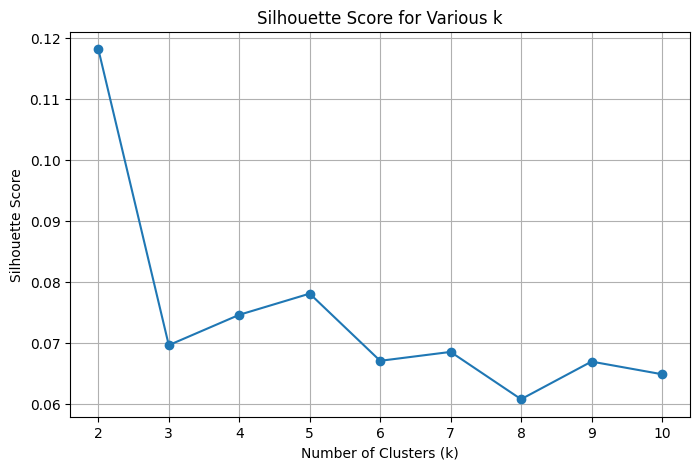

In [32]:
from sklearn.metrics import silhouette_score

k_range = range(2, 11)  # start from 2 (silhouette undefined for k=1)
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score for Various k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [50]:
# another cluster technique. graph it next 
from sklearn.cluster import DBSCAN, AgglomerativeClustering

# DBSCAN
db = DBSCAN(eps=2, min_samples=5)
db_labels = db.fit_predict(X_scaled)

# Agglomerative
agg = AgglomerativeClustering(n_clusters=3)
agg_labels = agg.fit_predict(X_scaled)


In [46]:
from sklearn.decomposition import PCA

# Reduce to 2D for plotting only
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_scaled)


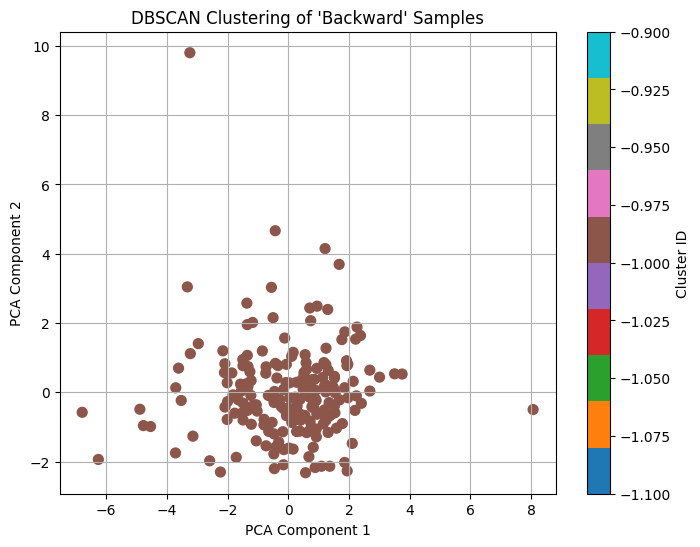

In [51]:
plt.figure(figsize=(8, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=db_labels, cmap='tab10', s=50)
plt.title("DBSCAN Clustering of 'Backward' Samples")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()


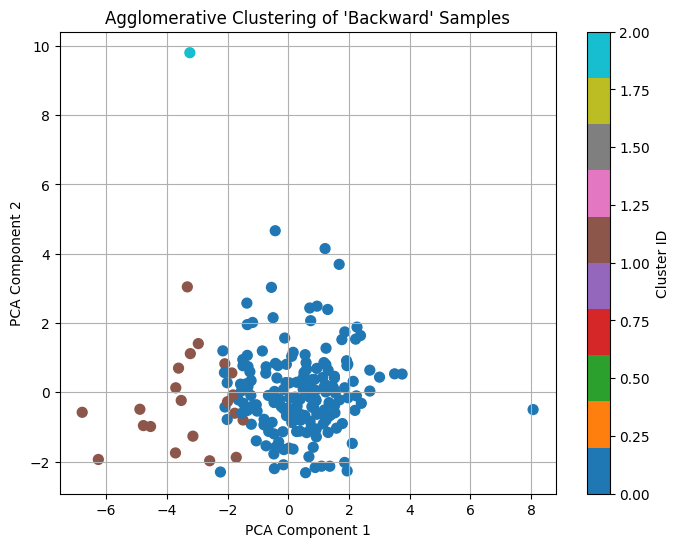

In [48]:
plt.figure(figsize=(8, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=agg_labels, cmap='tab10', s=50)
plt.title("Agglomerative Clustering of 'Backward' Samples")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.grid(True)
plt.show()


In [54]:
# reports how many clusters each algorithm found.
import numpy as np

print("# of KMeans clusters:", len(set(clusters)))
print("# of DBSCAN clusters:", len(set(db_labels)) - (1 if -1 in db_labels else 0))
print("# of Agglomerative clusters:", len(set(agg_labels)))


# of KMeans clusters: 3
# of DBSCAN clusters: 0
# of Agglomerative clusters: 3


In [38]:
# Compares the silhouette score across clustering algorithms. 1 best, 0 overlapping, -1 bad
from sklearn.metrics import silhouette_score

print("KMeans Silhouette Score:", silhouette_score(X_scaled, clusters))
print("DBSCAN Silhouette Score:", silhouette_score(X_scaled, db_labels) if len(set(db_labels)) > 1 else "N/A")
print("Agglomerative Silhouette Score:", silhouette_score(X_scaled, agg_labels))


KMeans Silhouette Score: 0.06961811517228289
DBSCAN Silhouette Score: N/A
Agglomerative Silhouette Score: 0.17416353405741478


In [39]:
# purpose: Assigns each point's cluster ID for KMeans, DBSCAN, and Agglomerative into the dataframe.
# Then, it computes summary statistics (mean) of pitch, tempo, and energy for each KMeans cluster.
# This lets you interpret the clustering
df_cleaned['kmeans_cluster'] = clusters
df_cleaned['dbscan_cluster'] = db_labels
df_cleaned['agg_cluster'] = agg_labels

# Example: Compare average pitch/tempo per cluster
kmeans_summary = df_cleaned.groupby("kmeans_cluster")[["pitch_mean", "tempo", "energy_mean"]].mean()
print("KMeans cluster summary:")
print(kmeans_summary)


KMeans cluster summary:
                pitch_mean       tempo  energy_mean
kmeans_cluster                                     
0               133.175510  165.236374     0.059279
1               158.613684  189.837144     0.040584
2               167.808493  155.833951     0.069089


In [53]:
# no DBSCAN summary since not >1 clusters 

# Agglomerative summary
agg_summary = df_cleaned.groupby("agg_cluster")[["pitch_mean", "tempo", "energy_mean"]].mean()
print("\nAgglomerative cluster summary:")
print(agg_summary)



Agglomerative cluster summary:
             pitch_mean       tempo  energy_mean
agg_cluster                                     
0            158.685663  173.436640     0.052855
1            118.885787  164.457892     0.042794
2            125.627649  156.250000     0.624123
